In [1]:
from tensorflow.keras import models, layers, optimizers, callbacks, backend
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams['figure.dpi']=150
import time
import pickle
import sys

/Users/nicolas/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/nicolas/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file 

In [2]:
data_1 = np.load("training/data/1OverF_1.npz")
data_2 = np.load("training/data/Lor_1.npz")
data_3 = np.load("training/data/1OverF-Lorf_1.npz")
c_data = np.append( data_1['arr_0'], np.append( data_2['arr_0'], data_3['arr_0'], axis=0 ), axis=0 )
T_in = data_1['arr_1']         # Time vector for data generation 
s_data = np.append( data_1['arr_2'], np.append( data_2['arr_2'], data_3['arr_2'], axis=0 ), axis=0 )
w0 = data_1['arr_3']           # Omega vector for data generation
T_train = data_1['arr_4']      # Time vector for training data (based on the experimental data)
w_train = data_1['arr_5']      # Omega vector for training data
T2_span = data_1['arr_6']      # T2 distribution

In [3]:
# For data interpolation
def interpData(x,y,xNew):
    f_interp = interp1d(x,y)
    yNew = f_interp(xNew)
    return yNew

# For preparing training data: Add random noise, then replace low values with zeros
# Run this cell multiple times to generate sets with different random noise but same underlying curves
def prepare_trainData(c_in,T_in,T_train,noiseMax=0.03,cutOff=0.03):
    c_train = interpData(T_in,c_in,T_train)
    for i in range(c_in.shape[0]):
        c_train[i,:] = c_train[i,:] + np.random.normal(0,noiseMax*2/3,size=c_train.shape[1])
        cut = np.squeeze(np.argwhere(c_train[i,:]<=cutOff+np.random.normal(0,noiseMax*2/3,1)))
    if cut.size > 1:
        c_train[i,cut[0]-1:] = 0
    elif cut.size == 1:
        c_train[i,cut-1:] = 0
    return c_train

In [4]:
nnps = 6 #-- noise number per sample
# Interpolate, add random noise to experimental conditions, cut the tail of the data
c_train_1set = prepare_trainData( c_data, T_in, T_train )
s_train_1set = interpData( w0, s_data, w_train )
d1 = np.shape( c_train_1set )[0]
d2 = np.shape( c_train_1set )[1]
d3 = np.shape( s_train_1set )[1]
c_train = np.zeros( ( d1*nnps, d2 ) )
s_train = np.zeros( ( d1*nnps, d3 ) )
for i in range(nnps):
    c_train_1set = prepare_trainData( c_data, T_in, T_train, noiseMax=0.015,cutOff=0.03 )
    c_train[i*d1:(i+1)*d1,:] = c_train_1set
    s_train[i*d1:(i+1)*d1,:] = s_train_1set

X = c_train
y = s_train
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)    

print("x_train = ",np.shape(x_train))
print("y_train = ",np.shape(y_train))
print("x_test = ",np.shape(x_test))
print("y_test = ",np.shape(y_test))
print("w0 = ",np.shape(w0))
print("w_train = ",np.shape(w_train))

x_train =  (85812, 147)
y_train =  (85812, 501)
x_test =  (15144, 147)
y_test =  (15144, 501)
w0 =  (4001,)
w_train =  (501,)


In [5]:
def get_model( filter_nb, kernel_size, pool_size, dropout_rate ):
    model = models.Sequential()
    model.add( layers.Input( shape=(x_train.shape[-1], 1) ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//2, kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//4,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    
    model.add( layers.Conv1D( filter_nb//4,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    model.add( layers.Conv1D( filter_nb//2,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    model.add( layers.Conv1D( filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    
    model.add( layers.Conv1D( filter_nb,kernel_size,activation="relu", padding='same' ) ) 
    model.add( layers.Conv1D( 1, kernel_size, activation="relu", padding='same' ) )
    model.add( layers.Flatten() )
    model.add( layers.Dropout( dropout_rate ) )
    model.add( layers.Dense(501, activation='linear') )  
    
    return model 

In [6]:
BATCH_SIZE = 64
EPOCHS = 20
INIT_LR = 1e-5
MAX_LR = 1e-3

model = get_model( filter_nb=40, kernel_size=48, pool_size=2, dropout_rate=0.05 )
model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 147, 40)           1960      
                                                                 
 conv1d_1 (Conv1D)           (None, 147, 40)           76840     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 40)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 74, 20)            38420     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 20)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)        

2023-07-07 20:08:44.815002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-07 20:08:44.815080: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## SINGLE MODEL TRAINING

In [7]:
LR = 0.001
BATCH_SIZE = 64
EPOCHS = 1000

reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=8,verbose=True,\
    mode="auto",min_delta=0.001,cooldown=0,min_lr=1e-6)
model = get_model( filter_nb=40, kernel_size=42, pool_size=2, dropout_rate=0.05 )
opt = optimizers.Adam(learning_rate=LR)
model.compile(loss='MAPE', optimizer=opt)
history_ = model.fit( x_train, y_train, BATCH_SIZE, epochs=EPOCHS,\
                         validation_data=(x_test, y_test), verbose=True, callbacks=[reduce_lr])

model.save('training/CNN_fil=40_REDUCE_minLR=1e-6_3_TYPES', overwrite=True)

Epoch 1/1000


2023-07-07 20:08:49.477227: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-07 20:08:49.912867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1341/1341 [==============================] - ETA: 0s - loss: 55.7154

2023-07-07 20:09:37.450018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1341/1341 [==============================] - 51s 37ms/step - loss: 55.7154 - val_loss: 34.1294 - lr: 0.0010
Epoch 2/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 32.3174 - val_loss: 29.2123 - lr: 0.0010
Epoch 3/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 25.7047 - val_loss: 23.7125 - lr: 0.0010
Epoch 4/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 23.0954 - val_loss: 22.0582 - lr: 0.0010
Epoch 5/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 21.5119 - val_loss: 19.7663 - lr: 0.0010
Epoch 6/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 20.2599 - val_loss: 18.5227 - lr: 0.0010
Epoch 7/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 19.8676 - val_loss: 17.7922 - lr: 0.0010
Epoch 8/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 18.7603 - val_loss: 22.7557 - lr: 0.0010
Epoch 9/1000
1341/1341 [=====================

1341/1341 [==============================] - ETA: 0s - loss: 10.9529
Epoch 66: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1341/1341 [==============================] - 49s 37ms/step - loss: 10.9529 - val_loss: 10.8099 - lr: 5.0000e-04
Epoch 67/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 9.9336 - val_loss: 10.3268 - lr: 2.5000e-04
Epoch 68/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 9.9706 - val_loss: 9.8428 - lr: 2.5000e-04
Epoch 69/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 9.8006 - val_loss: 15.7155 - lr: 2.5000e-04
Epoch 70/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 9.8979 - val_loss: 9.9918 - lr: 2.5000e-04
Epoch 71/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 9.8160 - val_loss: 9.3918 - lr: 2.5000e-04
Epoch 72/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 9.7272 - val_loss: 10.1027 - lr: 2.5000

1341/1341 [==============================] - 49s 37ms/step - loss: 8.1343 - val_loss: 8.3285 - lr: 6.2500e-05
Epoch 129/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 8.1552 - val_loss: 10.0886 - lr: 6.2500e-05
Epoch 130/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 8.1229 - val_loss: 9.1234 - lr: 6.2500e-05
Epoch 131/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 8.0980 - val_loss: 8.7391 - lr: 6.2500e-05
Epoch 132/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 8.1324 - val_loss: 8.4823 - lr: 6.2500e-05
Epoch 133/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 8.1136 - val_loss: 8.5571 - lr: 6.2500e-05
Epoch 134/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 8.0832 - val_loss: 8.5655 - lr: 6.2500e-05
Epoch 135/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 8.0790 - val_loss: 8.7356 - lr: 6.2500e-05
Epoch 136/1000

Epoch 187/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.6263 - val_loss: 8.5892 - lr: 1.0000e-06
Epoch 188/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.6204 - val_loss: 8.6389 - lr: 1.0000e-06
Epoch 189/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.6209 - val_loss: 8.6125 - lr: 1.0000e-06
Epoch 190/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.6220 - val_loss: 8.6272 - lr: 1.0000e-06
Epoch 191/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.6169 - val_loss: 8.6098 - lr: 1.0000e-06
Epoch 192/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.6280 - val_loss: 8.6407 - lr: 1.0000e-06
Epoch 193/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.6255 - val_loss: 8.6228 - lr: 1.0000e-06
Epoch 194/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.6275 - val_loss: 8.5964 - lr: 1.0000e-06


1341/1341 [==============================] - 49s 37ms/step - loss: 7.6109 - val_loss: 8.6258 - lr: 1.0000e-06
Epoch 253/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.6054 - val_loss: 8.6565 - lr: 1.0000e-06
Epoch 254/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.6036 - val_loss: 8.6010 - lr: 1.0000e-06
Epoch 255/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 7.6064 - val_loss: 8.7116 - lr: 1.0000e-06
Epoch 256/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.6050 - val_loss: 8.7056 - lr: 1.0000e-06
Epoch 257/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.6019 - val_loss: 8.6583 - lr: 1.0000e-06
Epoch 258/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 7.6064 - val_loss: 8.6567 - lr: 1.0000e-06
Epoch 259/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.6063 - val_loss: 8.5651 - lr: 1.0000e-06
Epoch 260/1000


1341/1341 [==============================] - 50s 37ms/step - loss: 7.5902 - val_loss: 8.6167 - lr: 1.0000e-06
Epoch 318/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5899 - val_loss: 8.6408 - lr: 1.0000e-06
Epoch 319/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5906 - val_loss: 8.6367 - lr: 1.0000e-06
Epoch 320/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5908 - val_loss: 8.6021 - lr: 1.0000e-06
Epoch 321/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5971 - val_loss: 8.6743 - lr: 1.0000e-06
Epoch 322/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5917 - val_loss: 8.6412 - lr: 1.0000e-06
Epoch 323/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5923 - val_loss: 8.6405 - lr: 1.0000e-06
Epoch 324/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5932 - val_loss: 8.6600 - lr: 1.0000e-06
Epoch 325/1000


1341/1341 [==============================] - 49s 37ms/step - loss: 7.5790 - val_loss: 8.5927 - lr: 1.0000e-06
Epoch 383/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5805 - val_loss: 8.6265 - lr: 1.0000e-06
Epoch 384/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5785 - val_loss: 8.5947 - lr: 1.0000e-06
Epoch 385/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5845 - val_loss: 8.7045 - lr: 1.0000e-06
Epoch 386/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5803 - val_loss: 8.6701 - lr: 1.0000e-06
Epoch 387/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 7.5815 - val_loss: 8.6583 - lr: 1.0000e-06
Epoch 388/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5813 - val_loss: 8.6324 - lr: 1.0000e-06
Epoch 389/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5822 - val_loss: 8.5968 - lr: 1.0000e-06
Epoch 390/1000


1341/1341 [==============================] - 49s 37ms/step - loss: 7.5678 - val_loss: 8.5862 - lr: 1.0000e-06
Epoch 448/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5644 - val_loss: 8.6001 - lr: 1.0000e-06
Epoch 449/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5641 - val_loss: 8.6333 - lr: 1.0000e-06
Epoch 450/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 7.5693 - val_loss: 8.6567 - lr: 1.0000e-06
Epoch 451/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5613 - val_loss: 8.6589 - lr: 1.0000e-06
Epoch 452/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5661 - val_loss: 8.6216 - lr: 1.0000e-06
Epoch 453/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5743 - val_loss: 8.5872 - lr: 1.0000e-06
Epoch 454/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5670 - val_loss: 8.5966 - lr: 1.0000e-06
Epoch 455/1000


1341/1341 [==============================] - 49s 37ms/step - loss: 7.5565 - val_loss: 8.5977 - lr: 1.0000e-06
Epoch 513/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5598 - val_loss: 8.6316 - lr: 1.0000e-06
Epoch 514/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5611 - val_loss: 8.6188 - lr: 1.0000e-06
Epoch 515/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 7.5588 - val_loss: 8.6066 - lr: 1.0000e-06
Epoch 516/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5589 - val_loss: 8.6182 - lr: 1.0000e-06
Epoch 517/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5536 - val_loss: 8.6302 - lr: 1.0000e-06
Epoch 518/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5533 - val_loss: 8.6071 - lr: 1.0000e-06
Epoch 519/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 7.5599 - val_loss: 8.6345 - lr: 1.0000e-06
Epoch 520/1000


1341/1341 [==============================] - 49s 37ms/step - loss: 7.5454 - val_loss: 8.6345 - lr: 1.0000e-06
Epoch 578/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5398 - val_loss: 8.6062 - lr: 1.0000e-06
Epoch 579/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5460 - val_loss: 8.6135 - lr: 1.0000e-06
Epoch 580/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5451 - val_loss: 8.6801 - lr: 1.0000e-06
Epoch 581/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5441 - val_loss: 8.5823 - lr: 1.0000e-06
Epoch 582/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5421 - val_loss: 8.6679 - lr: 1.0000e-06
Epoch 583/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5451 - val_loss: 8.5781 - lr: 1.0000e-06
Epoch 584/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5421 - val_loss: 8.6421 - lr: 1.0000e-06
Epoch 585/1000


1341/1341 [==============================] - 49s 37ms/step - loss: 7.5328 - val_loss: 8.6408 - lr: 1.0000e-06
Epoch 643/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5319 - val_loss: 8.6057 - lr: 1.0000e-06
Epoch 644/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 7.5334 - val_loss: 8.6050 - lr: 1.0000e-06
Epoch 645/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5321 - val_loss: 8.5861 - lr: 1.0000e-06
Epoch 646/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 7.5328 - val_loss: 8.6085 - lr: 1.0000e-06
Epoch 647/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 7.5310 - val_loss: 8.6108 - lr: 1.0000e-06
Epoch 648/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5310 - val_loss: 8.6224 - lr: 1.0000e-06
Epoch 649/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5304 - val_loss: 8.6579 - lr: 1.0000e-06
Epoch 650/1000


1341/1341 [==============================] - 49s 37ms/step - loss: 7.5291 - val_loss: 8.6060 - lr: 1.0000e-06
Epoch 708/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5277 - val_loss: 8.6266 - lr: 1.0000e-06
Epoch 709/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5208 - val_loss: 8.6226 - lr: 1.0000e-06
Epoch 710/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5254 - val_loss: 8.5997 - lr: 1.0000e-06
Epoch 711/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5268 - val_loss: 8.6714 - lr: 1.0000e-06
Epoch 712/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5250 - val_loss: 8.6198 - lr: 1.0000e-06
Epoch 713/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5219 - val_loss: 8.6895 - lr: 1.0000e-06
Epoch 714/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5295 - val_loss: 8.6400 - lr: 1.0000e-06
Epoch 715/1000


1341/1341 [==============================] - 49s 37ms/step - loss: 7.5117 - val_loss: 8.6227 - lr: 1.0000e-06
Epoch 773/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 7.5134 - val_loss: 8.6134 - lr: 1.0000e-06
Epoch 774/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5152 - val_loss: 8.6248 - lr: 1.0000e-06
Epoch 775/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 7.5157 - val_loss: 8.6420 - lr: 1.0000e-06
Epoch 776/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5127 - val_loss: 8.5987 - lr: 1.0000e-06
Epoch 777/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 7.5116 - val_loss: 8.6523 - lr: 1.0000e-06
Epoch 778/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 7.5161 - val_loss: 8.5856 - lr: 1.0000e-06
Epoch 779/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5168 - val_loss: 8.6166 - lr: 1.0000e-06
Epoch 780/1000


1341/1341 [==============================] - 49s 37ms/step - loss: 7.5047 - val_loss: 8.5929 - lr: 1.0000e-06
Epoch 838/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5042 - val_loss: 8.5992 - lr: 1.0000e-06
Epoch 839/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5061 - val_loss: 8.5945 - lr: 1.0000e-06
Epoch 840/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5008 - val_loss: 8.6024 - lr: 1.0000e-06
Epoch 841/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.4998 - val_loss: 8.6227 - lr: 1.0000e-06
Epoch 842/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5080 - val_loss: 8.6508 - lr: 1.0000e-06
Epoch 843/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5098 - val_loss: 8.6002 - lr: 1.0000e-06
Epoch 844/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.4997 - val_loss: 8.6227 - lr: 1.0000e-06
Epoch 845/1000


1341/1341 [==============================] - 50s 37ms/step - loss: 7.4929 - val_loss: 8.6435 - lr: 1.0000e-06
Epoch 903/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.4970 - val_loss: 8.6186 - lr: 1.0000e-06
Epoch 904/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.4942 - val_loss: 8.6246 - lr: 1.0000e-06
Epoch 905/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.4954 - val_loss: 8.6317 - lr: 1.0000e-06
Epoch 906/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.4982 - val_loss: 8.6220 - lr: 1.0000e-06
Epoch 907/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.5017 - val_loss: 8.6734 - lr: 1.0000e-06
Epoch 908/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.4942 - val_loss: 8.6692 - lr: 1.0000e-06
Epoch 909/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.4922 - val_loss: 8.6475 - lr: 1.0000e-06
Epoch 910/1000


1341/1341 [==============================] - 50s 37ms/step - loss: 7.4861 - val_loss: 8.6622 - lr: 1.0000e-06
Epoch 968/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.4913 - val_loss: 8.6495 - lr: 1.0000e-06
Epoch 969/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.4794 - val_loss: 8.6210 - lr: 1.0000e-06
Epoch 970/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.4863 - val_loss: 8.6437 - lr: 1.0000e-06
Epoch 971/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.4825 - val_loss: 8.6220 - lr: 1.0000e-06
Epoch 972/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.4754 - val_loss: 8.6452 - lr: 1.0000e-06
Epoch 973/1000
1341/1341 [==============================] - 49s 37ms/step - loss: 7.4859 - val_loss: 8.6445 - lr: 1.0000e-06
Epoch 974/1000
1341/1341 [==============================] - 50s 37ms/step - loss: 7.4841 - val_loss: 8.6234 - lr: 1.0000e-06
Epoch 975/1000


INFO:tensorflow:Assets written to: training/CNN_fil=40_REDUCE_minLR=1e-6_3_TYPES/assets


INFO:tensorflow:Assets written to: training/CNN_fil=40_REDUCE_minLR=1e-6_3_TYPES/assets


In [8]:
model.save('training/CNN_1_FULL_LAYERS_LASTEST_fil=40_REDUCE_minLR=1e-5_MORE_DATA', overwrite=True)

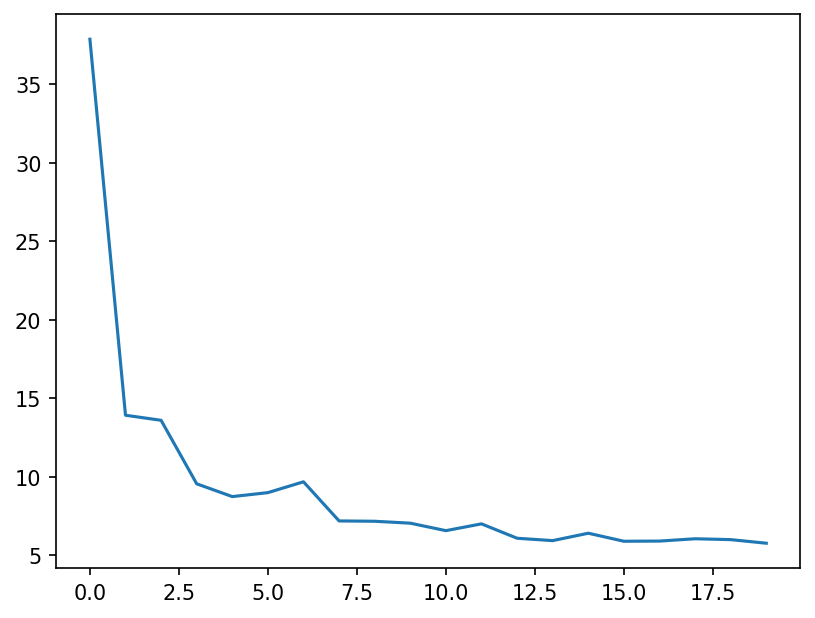

In [8]:
#tot_history = history_.history['val_loss'] 
tot_history = np.append( history1_.history['val_loss'],history2_.history['val_loss'] )
tot_history = np.append( tot_history,history3_.history['val_loss'] )
tot_history = np.append( tot_history,history4_.history['val_loss'] )
tot_history = np.append( tot_history,history5_.history['val_loss'] )

#epochs = np.arange( 0, EPOCHS )
epochs = np.arange( 0, EPOCHS1+EPOCHS2+EPOCHS3+EPOCHS4+EPOCHS5 )

plt.plot( epochs, tot_history )
plt.show()


##  MODEL TESTING

In [8]:
reconstructed_model = models.load_model( "training/CNN_fil=40_REDUCE_minLR=1e-6_3_TYPES", compile=False )

In [9]:
probability_model = tf.keras.Sequential([reconstructed_model])
#probability_model = tf.keras.Sequential([model])
predictions_best = probability_model.predict(x_test)

  8/474 [..............................] - ETA: 3s  

2023-07-08 16:58:14.300646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


474/474 [==============================] - 4s 8ms/step


(0.0, 500000.0)

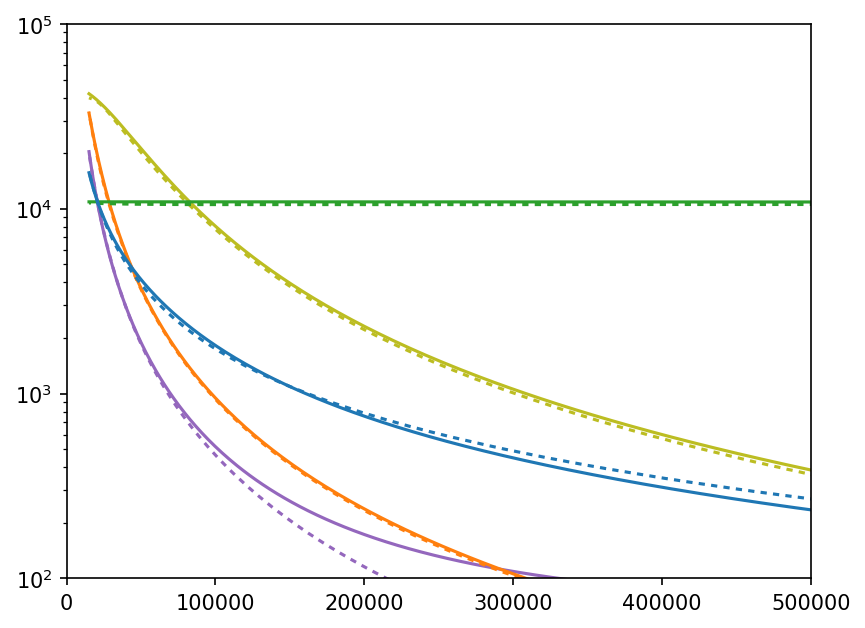

In [12]:
plt.subplot(1, 1, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(5,) )
for i in rand_set:
    plt.plot(w_train, y_test[i,:],color='C'+str(i))
    plt.plot(w_train, predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')
plt.ylim(1e2,1e5)
plt.xlim(0, 0.5e6)

In [ ]:
matplotlib.rcParams['figure.dpi']=300
plt.subplot(1, 2, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(30,) )
for i in rand_set:
    plt.plot(w0,y_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')

plt.subplot(1, 2, 2)
for i in rand_set:
    plt.plot( x_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))